In [1]:
# Description: Plot Figure 1 (schematic with mean flow geometry, horizontal scales and types of bathymetry).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        June/2022

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hdf5storage import loadmat
from cmocean.cm import balance

In [3]:
def sech(y):
    return 1/np.cosh(y)

In [4]:
plt.close("all")

cmap = balance
ht = 1
htdimfac = 31.8 # [m]
N = 256
L = 2
Lj = L/10
kt = 10*np.pi
U0 = 1
dx = L/N
dy = dx
x = np.arange(0, N)
x, y = np.meshgrid(x*dx, x*dx - L/2)
y0 = y[:, 0]

# 1D zonal ridge topography.
h1Dmc = ht*np.cos(kt*y)
h2Dmc = ht*np.cos(kt*x)*np.cos(kt*y) # 2D monochromatic topography.

fname_hrand = "../../code_simulations/hrand256Km2tk10filtnx32.mat"
h2Dbb = loadmat(fname_hrand)["h"]
h2Dbb = h2Dbb*ht*0.5 # ht is rms in random topography. The factor 1/2 is the rms of sin(x)sin(y).

htdim1Dmc = h1Dmc*htdimfac
htdim2Dmc = h2Dmc*htdimfac
htdim2Dbb = h2Dbb*htdimfac
htdimmax = np.ceil(np.abs(htdim2Dbb).max())

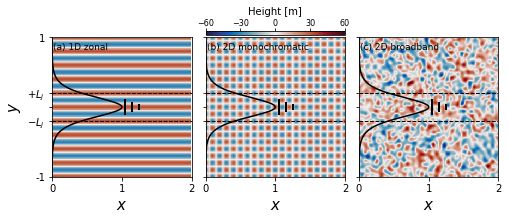

In [5]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8, 4))
ax1, ax2, ax3 = ax
ax1.axis("square"); ax2.axis("square"); ax3.axis("square")

cs1 = ax1.pcolormesh(x, y, htdim1Dmc, vmin=-htdimmax, vmax=htdimmax, cmap=cmap)
cs2 = ax2.pcolormesh(x, y, htdim2Dmc, vmin=-htdimmax, vmax=htdimmax, cmap=cmap)
cs3 = ax3.pcolormesh(x, y, htdim2Dbb, vmin=-htdimmax, vmax=htdimmax, cmap=cmap)

ax1.set_xticks((0, L/2, L)); ax1.set_yticks((-L/2, -Lj, 0, Lj, L/2))
ax1.set_xlim(0, L); ax1.set_ylim(-L/2, L/2)
ax1.axhline(-Lj, color="k", linestyle="dashed", linewidth=1); ax1.axhline(Lj, color="k", linestyle="dashed", linewidth=1)
ax2.axhline(-Lj, color="k", linestyle="dashed", linewidth=1); ax2.axhline(Lj, color="k", linestyle="dashed", linewidth=1)
ax3.axhline(-Lj, color="k", linestyle="dashed", linewidth=1); ax3.axhline(Lj, color="k", linestyle="dashed", linewidth=1)

# Overlay the mean Bickley jet on the topographies.
U = U0*sech(y0/Lj)**2
ax1.plot(U, y0, color="k")
ax2.plot(U, y0, color="k")
ax3.plot(U, y0, color="k")

# Overlay the deformation radii associated with the narrow, medium and wide jet cases.
Ld1narrow = Lj     # Lj = 1*Ld1.
Ld1medium = Lj/1.7 # Lj = 1.7*Ld1.
Ld1wide = Lj/4     # Lj = 4*Ld1.
xLd, dxLd = 1.05, 0.1

ax1.plot([xLd, xLd], [-Ld1narrow/2, Ld1narrow/2], color="k", linewidth=2); ax1.plot([xLd + dxLd, xLd + dxLd], [-Ld1medium/2, Ld1medium/2], color="k", linewidth=2); ax1.plot([xLd + 2*dxLd, xLd + 2*dxLd], [-Ld1wide/2, Ld1wide/2], color="k", linewidth=2)
ax2.plot([xLd, xLd], [-Ld1narrow/2, Ld1narrow/2], color="k", linewidth=2); ax2.plot([xLd + dxLd, xLd + dxLd], [-Ld1medium/2, Ld1medium/2], color="k", linewidth=2); ax2.plot([xLd + 2*dxLd, xLd + 2*dxLd], [-Ld1wide/2, Ld1wide/2], color="k", linewidth=2)
ax3.plot([xLd, xLd], [-Ld1narrow/2, Ld1narrow/2], color="k", linewidth=2); ax3.plot([xLd + dxLd, xLd + dxLd], [-Ld1medium/2, Ld1medium/2], color="k", linewidth=2); ax3.plot([xLd + 2*dxLd, xLd + 2*dxLd], [-Ld1wide/2, Ld1wide/2], color="k", linewidth=2)

cax = ax2.inset_axes([0, 1.02, 1.0, 0.025])
cb = fig.colorbar(mappable=cs3, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position("top"); cb.ax.xaxis.set_label_position("top")
cb.set_ticks([-htdimmax, -htdimmax/2, 0, htdimmax/2, htdimmax])
cb.ax.xaxis.set_tick_params(labelsize=8, pad=0)
cb.set_label(r"Height [m]", fontsize=10, fontweight="normal")
ax1.set_xlabel(r"$x$", fontsize=15, fontweight="black")
ax2.set_xlabel(r"$x$", fontsize=15, fontweight="black")
ax3.set_xlabel(r"$x$", fontsize=15, fontweight="black")
ax1.set_ylabel(r"$y$", fontsize=15, fontweight="black")

xt, yt = 0.01, 0.9
kwtxt = dict(fontsize=9, color="k", fontweight="light", ha="left", va="bottom")
ax1.text(xt, yt, r"(a) 1D zonal", transform=ax1.transAxes, **kwtxt)
ax2.text(xt, yt, r"(b) 2D monochromatic", transform=ax2.transAxes, **kwtxt)
ax3.text(xt, yt, r"(c) 2D broadband", transform=ax3.transAxes, **kwtxt)
ax1.yaxis.set_ticklabels([-1, "$-L_j$", "", "$+L_j$", 1])
fig.subplots_adjust(wspace=0.1)

fig.savefig("fig01.png", bbox_inches="tight", dpi=150)
plt.show()